In [140]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import bisect, newton, toms748

In [111]:
# LINEAR CROSS INHIBITION:
def f0_equation_linci(f0, pis, qs, l, lci, permutation):
    # as a solution of a second degree poly is involved, choose branch by setting +1 or -1
    Nsites = len(pis)
    rs = [1/q for q in qs]
    sumval = 0.0
    for i in range(Nsites):
        sumval += (rs[i] + permutation[i]*np.sqrt(((l+lci)*f0 - rs[i] - lci)**2 - 4*lci*(1-l)*pis[i]*f0))
    sumval = sumval/(2*lci)
    return 1 - f0 + (Nsites*(l+lci)*f0-Nsites*lci)/(2*lci) - sumval

def f0_eq_sqrt_zeros(pi, q, l, lci):
    r = 1/q
    a = (l + lci)**2
    b = (-2*(l+lci)*(r+lci) - 4*lci*(1-l)*pi)
    c = (r+lci)**2
    arrel = np.sqrt(b**2 - 4*a*c)
    return (-b+arrel)/(2*a), (-b-arrel)/(2*a)

def falpha_linci(f0, pi, q, l, lci, branch):
    r = 1/q
    # rootval = np.sqrt(((l+lci)*f0 - r - lci)**2 - 4*lci*(1-l)*pi*f0)
    a = lci
    b = -r-lci+(l+lci)*f0
    c = f0*(1-l)*pi
    arrel = np.sqrt(b**2 - 4*a*c)
    # return (-b+arrel)/(2*a), (-b-arrel)/(2*a)
    return (-b + branch*arrel)/(2*a)
    

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_38557/1414364121.py:8: RuntimeWarning: invalid value encountered in sqrt
  sumval += (rs[i] + permutation[i]*np.sqrt(((l+lci)*f0 - rs[i] - lci)**2 - 4*lci*(1-l)*pis[i]*f0))


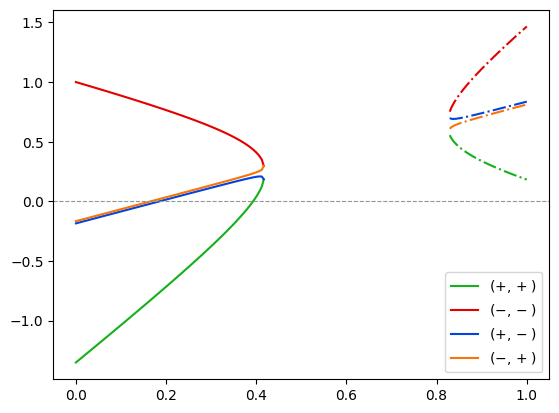

In [137]:
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.6, 0.6
# pis, qs, l, lci = [0.2, 0.2], [9.0, 10.0], 0.2, 0.2

f0s1 = f0_eq_sqrt_zeros(pis[0], qs[0], l, lci)
f0s2 = f0_eq_sqrt_zeros(pis[1], qs[1], l, lci)
f0sProb = sorted(f0s1 + f0s2)

f0s_lower = np.linspace(0.0, f0sProb[0], 100)
f0s_upper = np.linspace(f0sProb[-1], 1.0, 100)

permutation = [+1, +1]
eqvals_pp_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_pp_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

permutation = [-1, -1]
eqvals_mm_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_mm_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

permutation = [+1, -1]
eqvals_pm_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_pm_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

permutation = [-1, +1]
eqvals_mp_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_mp_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

fig, ax = plt.subplots()
ax.plot(f0s_lower, eqvals_pp_lower, color='xkcd:green', label='$(+,+)$')
ax.plot(f0s_upper, eqvals_pp_upper, color='xkcd:green', ls='-.')

ax.plot(f0s_lower, eqvals_mm_lower, color='xkcd:red', label='$(-,-)$')
ax.plot(f0s_upper, eqvals_mm_upper, color='xkcd:red', ls='-.')

ax.plot(f0s_lower, eqvals_pm_lower, color='xkcd:blue', label='$(+,-)$')
ax.plot(f0s_upper, eqvals_pm_upper, color='xkcd:blue', ls='-.')

ax.plot(f0s_lower, eqvals_mp_lower, color='xkcd:orange', label='$(-,+)$')
ax.plot(f0s_upper, eqvals_mp_upper, color='xkcd:orange', ls='-.')

ax.legend()

ax.axhline(0, 0,1, ls='--', lw=0.8, color='xkcd:gray')

In [138]:
permutations = (+1, +1), (+1, -1), (-1, +1), (-1, -1)
sols_f0_perm = {}

for permutation in permutations:
    args = [pis, qs, l, lci, permutation]
    if f0_equation_linci(0.0, *args)*f0_equation_linci(f0sProb[0], *args) < 0:
        a = bisect(f0_equation_linci, 0.0, f0sProb[0], args=(pis, qs, l, lci, permutation))
        sols_f0_perm[permutation] = a

sols_fs_perm = {}
for permutation,f0 in sols_f0_perm.items():
    f1 = falpha_linci(f0, pis[0], qs[0], l, lci, permutation[0])
    f2 = falpha_linci(f0, pis[1], qs[1], l, lci, permutation[1])
    sols_fs_perm[permutation] = [f0, f1, f2]
    

In [139]:
sols_fs_perm

{(1, 1): [0.3929690394231026, 0.3164637304137582, 0.2905672301666127],
 (1, -1): [0.18556057786706026, 0.7985730161805377, 0.015866405950984014],
 (-1, 1): [0.16636348629769296, 0.013215363222788315, 0.8204211504793304]}

In [130]:
for v in sols_fs_perm.values():
    print(sum(v))

1.0000000000118805


## Nonlinear crosss inhibition (2 sites, only site 2 inhibits)

In [156]:
def f0poly_sols_nlinci(pis, qs, l, lci):
    rs = [1/q for q in qs]
    pi1, pi2 = pis
    r1, r2 = rs
    a = -(l**2)
    b = l*(l+lci+r1+r2+(1-l)*(pi1+pi2))
    c = -l*(lci+r1+r2) - (1-l)*(pi1*r2+pi2*r1+pi2*lci) - r1*r2 - r2*lci
    d = r1*r2 + r2*lci
     # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,math.sqrt(-1*radicand0))
        else:
            root0 = complex(math.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, math.sqrt(3))/2
    f0_roots, f0_roots_abs = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        f0_roots.append(f0_root), f0_roots_abs.append(abs(f0_root))
    return f0_roots_abs

def fs_sols_nlinci(f0, pis, qs, l, lci):
    rs = [1/q for q in qs]
    f1 = f0*(1-l)*pis[0]/(lci + rs[0] - l*f0)
    f2 = f0*(1-l)*pis[1]/(rs[1] - l*f0)
    return f1,f2



In [158]:
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.6, 0.6
f0s = f0poly_sols_nlinci(pis, qs, l, lci)
# print(f0s)
# for f0 in f0s:
#     print(f0, fs_sols_nlinci(f0, pis, qs, l, lci))


TypeError: can't multiply sequence by non-int of type 'float'

In [155]:
f0s

[1.4455220592373053, 0.15435288540478773, 0.8853102405430922]